### Imports & Downloads

In [1]:
!pip install emoji
!pip install ftfy


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import emoji

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

from ftfy import fix_encoding # https://github.com/rspeer/python-ftfy

In [3]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [4]:
stop_words = stopwords.words()

### Loading the data

In [5]:
#  avoid characters of text column to be cut off by default Pandas DataFrame limitations
pd.set_option('display.max_colwidth', 400)

In [6]:
df_raw_val = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\test.csv", index_col=0,
                         encoding="utf-8-sig")
df_raw_val.head()

,tweet
id,
31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [7]:
df_raw_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17197 entries, 31963 to 49159
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   17197 non-null  object
dtypes: object(1)
memory usage: 268.7+ KB


In [8]:
df_raw_train = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train.csv", index_col=0,
                           encoding="utf-8-sig")
df_raw_train.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0,factsguide: society now #motivation


In [9]:
df_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB


In [10]:
df = df_raw_train.copy()

### Allgemeines Data-Cleaning

#### Encoding-fix

In [11]:
df["tweet"] = df['tweet'].apply(fix_encoding)

#### Duplikate, NaNs, Ausreißer

In [12]:
df.label.unique() # keine Inkonsistenzen beim Label

array([0, 1], dtype=int64)

In [13]:
df.isna().sum()

label    0
tweet    0
dtype: int64

In [14]:
df.duplicated().sum()

2432

In [15]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [16]:
df["char_count"] = df["tweet"].str.len()
df["word_count"] = df["tweet"].str.split().str.len()
df = df.reset_index(drop=True)

In [17]:
df["char_count"].describe()

count    29530.000000
mean        83.001998
std         29.412117
min         10.000000
25%         61.000000
50%         87.000000
75%        106.000000
max        181.000000
Name: char_count, dtype: float64

Text(0, 0.5, 'Number of Tweets')

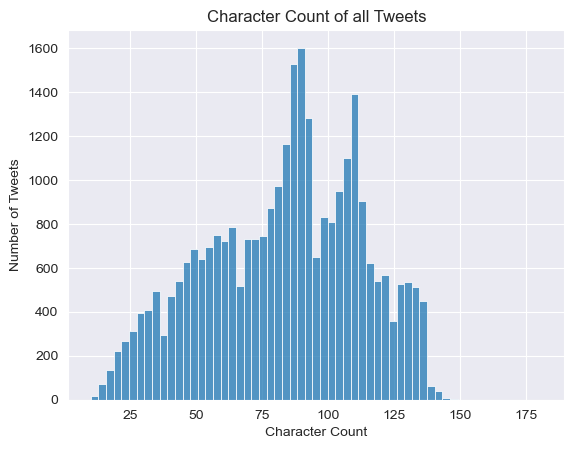

In [18]:
sns.histplot(df["char_count"])

plt.title('Character Count of all Tweets')

plt.xlabel('Character Count')
plt.ylabel('Number of Tweets')

Text(0, 0.5, 'Character Count')

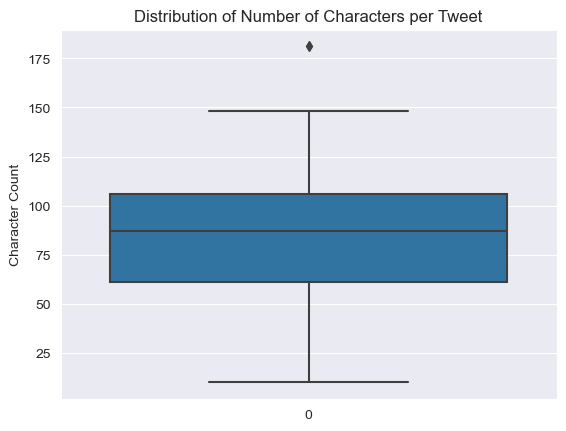

In [19]:
sns.boxplot(df["char_count"])

plt.title('Distribution of Number of Characters per Tweet')

plt.ylabel('Character Count')

In [20]:
df["word_count"].describe()

count    29530.000000
mean        13.249001
std          5.553023
min          2.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         34.000000
Name: word_count, dtype: float64

Text(0, 0.5, 'Number of Tweets')

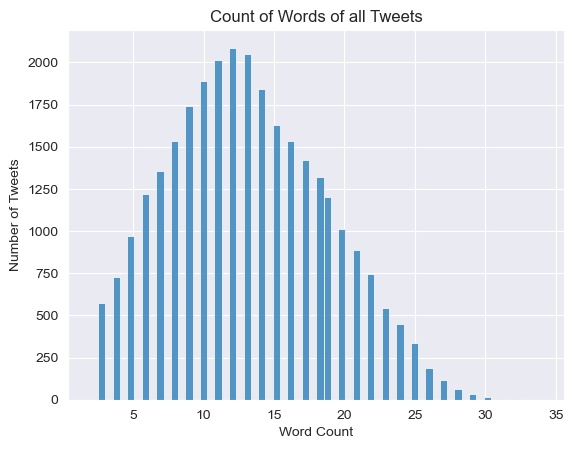

In [21]:
sns.histplot(df["word_count"])
plt.title('Count of Words of all Tweets')
plt.xlabel('Word Count')
plt.ylabel('Number of Tweets')

Text(0, 0.5, 'Number of Words')

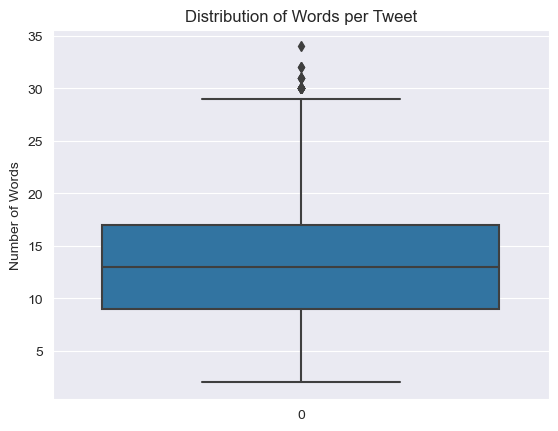

In [22]:
sns.boxplot(data=df["word_count"])
plt.title('Distribution of Words per Tweet')
plt.ylabel('Number of Words')

In [23]:
def find_outlier(data):
    for num_col in data.select_dtypes(["number"]).columns:
        sd = data[num_col].std()
        mean = data[num_col].mean()
        result = [out for out in data[num_col] if (out > mean + 3 * sd) or (out < mean - 3 * sd)]
        print()
        print("Column: ", num_col)
        print("Mean: ", mean, "; Std: ", sd)
        print("Outlier: ", len(result), "; Values: ", sorted(result))

In [24]:
find_outlier(df[["char_count", "word_count"]])


Column:  char_count
Mean:  83.00199796816797 ; Std:  29.412116595005582
Outlier:  1 ; Values:  [181]

Column:  word_count
Mean:  13.249001015916017 ; Std:  5.553022843649177
Outlier:  26 ; Values:  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 34]


In [25]:
df = df[df["char_count"] < 181]
df = df[df["word_count"] < 30]
df.drop(['char_count', 'word_count'], axis=1, inplace=True)

In [26]:
print(df.count())
print(df_raw_train.count())
print(df.count() - df_raw_train.count())
print((df.count() / df_raw_train.count() - 1) * 100)

label    29503
tweet    29503
dtype: int64
label    31962
tweet    31962
dtype: int64
label   -2459
tweet   -2459
dtype: int64
label   -7.693511
tweet   -7.693511
dtype: float64


### Spezielles Data-Cleaning für Textanalyse

#### Step 1: Normalisierung Groß-/Kleinschreibung

In [27]:
def normalize_text(text):
    text = text.lower()
    return text

In [28]:
df["tweet_cleaned_step1"] = df['tweet'].apply(normalize_text)

In [29]:
df.head()

,label,tweet,tweet_cleaned_step1
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦
4,0,factsguide: society now #motivation,factsguide: society now #motivation


#### Step 2: Abkürzungen/Slang

In [30]:
def remove_short_forms(text):
    text = re.sub("isn't", 'is not', text)
    text = re.sub("he's", 'he is', text)
    text = re.sub("wasn't", 'was not', text)
    text = re.sub("there's", 'there is', text)
    text = re.sub("couldn't", 'could not', text)
    text = re.sub("won't", 'will not', text)
    text = re.sub("they're", 'they are', text)
    text = re.sub("she's", 'she is', text)
    text = re.sub("There's", 'there is', text)
    text = re.sub("wouldn't", 'would not', text)
    text = re.sub("haven't", 'have not', text)
    text = re.sub("That's", 'That is', text)
    text = re.sub("you've", 'you have', text)
    text = re.sub("He's", 'He is', text)
    text = re.sub("what's", 'what is', text)
    text = re.sub("weren't", 'were not', text)
    text = re.sub("we're", 'we are', text)
    text = re.sub("hasn't", 'has not', text)
    text = re.sub("you'd", 'you would', text)
    text = re.sub("shouldn't", 'should not', text)
    text = re.sub("let's", 'let us', text)
    text = re.sub("they've", 'they have', text)
    text = re.sub("You'll", 'You will', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub("we've", 'we have', text)
    text = re.sub("it's", 'it is', text)
    text = re.sub("don't", 'do not', text)
    text = re.sub("that´s", 'that is', text)
    text = re.sub("I´m", 'I am', text)
    text = re.sub("it’s", 'it is', text)
    text = re.sub("she´s", 'she is', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('I’m', 'I am', text)
    text = re.sub('I’d', 'I did', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('there’s', 'there is', text)

    return text

In [31]:
# https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing
def convert_slang(text):
    text = re.sub("$",'dollar', text)
    text = re.sub("€",'euro', text)
    text = re.sub("4ao",'for adults only', text)
    text = re.sub("a.m",'before midday', text)
    text = re.sub("a3",'anytime anywhere anyplace', text)
    text = re.sub("aamof",'as a matter of fact', text)
    text = re.sub("acct",'account', text)
    text = re.sub("adih",'another day in hell', text)
    text = re.sub("afaic",'as far as i am concerned', text)
    text = re.sub("afaict",'as far as i can tell', text)
    text = re.sub("afaik",'as far as i know', text)
    text = re.sub("afair",'as far as i remember', text)
    text = re.sub("afk",'away from keyboard', text)
    text = re.sub("app",'application', text)
    text = re.sub("approx",'approximately', text)
    text = re.sub("apps",'applications', text)
    text = re.sub("asap",'as soon as possible', text)
    text = re.sub("asl",'age, sex, location', text)
    text = re.sub("atk",'at the keyboard', text)
    text = re.sub("ave.",'avenue', text)
    text = re.sub("aymm",'are you my mother', text)
    text = re.sub("ayor",'at your own risk', text)
    text = re.sub("b&b",'bed and breakfast', text)
    text = re.sub("b+b",'bed and breakfast', text)
    text = re.sub("b.c",'before christ', text)
    text = re.sub("b2b",'business to business', text)
    text = re.sub("b2c",'business to customer', text)
    text = re.sub("b4",'before', text)
    text = re.sub("b4n",'bye for now', text)
    text = re.sub("b@u",'back at you', text)
    text = re.sub("bae",'before anyone else', text)
    text = re.sub("bak",'back at keyboard', text)
    text = re.sub("bbbg",'bye bye be good', text)
    text = re.sub("bbc",'british broadcasting corporation', text)
    text = re.sub("bbias",'be back in a second', text)
    text = re.sub("bbl",'be back later', text)
    text = re.sub("bbs",'be back soon', text)
    text = re.sub("be4",'before', text)
    text = re.sub("bfn",'bye for now', text)
    text = re.sub("blvd",'boulevard', text)
    text = re.sub("bout",'about', text)
    text = re.sub("brb",'be right back', text)
    text = re.sub("bros",'brothers', text)
    text = re.sub("brt",'be right there', text)
    text = re.sub("bsaaw",'big smile and a wink', text)
    text = re.sub("btw",'by the way', text)
    text = re.sub("bwl",'bursting with laughter', text)
    text = re.sub("c/o",'care of', text)
    text = re.sub("cet",'central european time', text)
    text = re.sub("cf",'compare', text)
    text = re.sub("cia",'central intelligence agency', text)
    text = re.sub("csl",'can not stop laughing', text)
    text = re.sub("cu",'see you', text)
    text = re.sub("cul8r",'see you later', text)
    text = re.sub("cv",'curriculum vitae', text)
    text = re.sub("cwot",'complete waste of time', text)
    text = re.sub("cya",'see you', text)
    text = re.sub("cyt",'see you tomorrow', text)
    text = re.sub("dae",'does anyone else', text)
    text = re.sub("dbmib",'do not bother me i am busy', text)
    text = re.sub("diy",'do it yourself', text)
    text = re.sub("dm",'direct message', text)
    text = re.sub("dwh",'during work hours', text)
    text = re.sub("e123",'easy as one two three', text)
    text = re.sub("eet",'eastern european time', text)
    text = re.sub("eg",'example', text)
    text = re.sub("embm",'early morning business meeting', text)
    text = re.sub("encl",'enclosed', text)
    text = re.sub("encl.",'enclosed', text)
    text = re.sub("etc",'and so on', text)
    text = re.sub("faq",'frequently asked questions', text)
    text = re.sub("fawc",'for anyone who cares', text)
    text = re.sub("fb",'facebook', text)
    text = re.sub("fc",'fingers crossed', text)
    text = re.sub("fig",'figure', text)
    text = re.sub("fimh",'forever in my heart', text)
    text = re.sub("ft.",'feet', text)
    text = re.sub("ft",'featuring', text)
    text = re.sub("ftl",'for the loss', text)
    text = re.sub("ftw",'for the win', text)
    text = re.sub("fwiw",'for what it is worth', text)
    text = re.sub("fyi",'for your information', text)
    text = re.sub("g9",'genius', text)
    text = re.sub("gahoy",'get a hold of yourself', text)
    text = re.sub("gal",'get a life', text)
    text = re.sub("gcse",'general certificate of secondary education', text)
    text = re.sub("gfn",'gone for now', text)
    text = re.sub("gg",'good game', text)
    text = re.sub("gl",'good luck', text)
    text = re.sub("glhf",'good luck have fun', text)
    text = re.sub("gmt",'greenwich mean time', text)
    text = re.sub("gmta",'great minds think alike', text)
    text = re.sub("gn",'good night', text)
    text = re.sub("g.o.a.t",'greatest of all time', text)
    text = re.sub("goat",'greatest of all time', text)
    text = re.sub("goi",'get over it', text)
    text = re.sub("gps",'global positioning system', text)
    text = re.sub("gr8",'great', text)
    text = re.sub("gratz",'congratulations', text)
    text = re.sub("gyal",'girl', text)
    text = re.sub("h&c",'hot and cold', text)
    text = re.sub("hp",'horsepower', text)
    text = re.sub("hr",'hour', text)
    text = re.sub("hrh",'his royal highness', text)
    text = re.sub("ht",'height', text)
    text = re.sub("ibrb",'i will be right back', text)
    text = re.sub("ic",'i see', text)
    text = re.sub("icq",'i seek you', text)
    text = re.sub("icymi",'in case you missed it', text)
    text = re.sub("idc",'i do not care', text)
    text = re.sub("idgadf",'i do not give a damn fuck', text)
    text = re.sub("idgaf",'i do not give a fuck', text)
    text = re.sub("idk",'i do not know', text)
    text = re.sub("ie",'that is', text)
    text = re.sub("i.e",'that is', text)
    text = re.sub("ifyp",'i feel your pain', text)
    text = re.sub("IG",'instagram', text)
    text = re.sub("iirc",'if i remember correctly', text)
    text = re.sub("ilu",'i love you', text)
    text = re.sub("ily",'i love you', text)
    text = re.sub("imho",'in my humble opinion', text)
    text = re.sub("imo",'in my opinion', text)
    text = re.sub("imu",'i miss you', text)
    text = re.sub("iow",'in other words', text)
    text = re.sub("irl",'in real life', text)
    text = re.sub("j4f",'just for fun', text)
    text = re.sub("jic",'just in case', text)
    text = re.sub("jk",'just kidding', text)
    text = re.sub("jsyk",'just so you know', text)
    text = re.sub("l8r",'later', text)
    text = re.sub("lb",'pound', text)
    text = re.sub("lbs",'pounds', text)
    text = re.sub("ldr",'long distance relationship', text)
    text = re.sub("lmao",'laugh my ass off', text)
    text = re.sub("lmfao",'laugh my fucking ass off', text)
    text = re.sub("lol",'laughing out loud', text)
    text = re.sub("ltd",'limited', text)
    text = re.sub("ltns",'long time no see', text)
    text = re.sub("m8",'mate', text)
    text = re.sub("mf",'motherfucker', text)
    text = re.sub("mfs",'motherfuckers', text)
    text = re.sub("mfw",'my face when', text)
    text = re.sub("mofo",'motherfucker', text)
    text = re.sub("mph",'miles per hour', text)
    text = re.sub("mr",'mister', text)
    text = re.sub("mrw",'my reaction when', text)
    text = re.sub("ms",'miss', text)
    text = re.sub("mte",'my thoughts exactly', text)
    text = re.sub("nagi",'not a good idea', text)
    text = re.sub("nbc",'national broadcasting company', text)
    text = re.sub("nbd",'not big deal', text)
    text = re.sub("nfs",'not for sale', text)
    text = re.sub("ngl",'not going to lie', text)
    text = re.sub("nhs",'national health service', text)
    text = re.sub("nrn",'no reply necessary', text)
    text = re.sub("nsfl",'not safe for life', text)
    text = re.sub("nsfw",'not safe for work', text)
    text = re.sub("nth",'nice to have', text)
    text = re.sub("nvr",'never', text)
    text = re.sub("nyc",'new york city', text)
    text = re.sub("oc",'original content', text)
    text = re.sub("og",'original', text)
    text = re.sub("ohp",'overhead projector', text)
    text = re.sub("oic",'oh i see', text)
    text = re.sub("omdb",'over my dead body', text)
    text = re.sub("omg",'oh my god', text)
    text = re.sub("omw",'on my way', text)
    text = re.sub("p.a",'per annum', text)
    text = re.sub("p.m",'after midday', text)
    text = re.sub("pm",'prime minister', text)
    text = re.sub("poc",'people of color', text)
    text = re.sub("pov",'point of view', text)
    text = re.sub("pp",'pages', text)
    text = re.sub("ppl",'people', text)
    text = re.sub("prw",'parents are watching', text)
    text = re.sub("ps",'postscript', text)
    text = re.sub("pt",'point', text)
    text = re.sub("ptb",'please text back', text)
    text = re.sub("pto",'please turn over', text)
    text = re.sub("qpsa",'what happens', text) #text = re.sub("que pasa', text)
    text = re.sub("ratchet",'rude', text)
    text = re.sub("rbtl",'read between the lines', text)
    text = re.sub("rlrt",'real life retweet', text)
    text = re.sub("rofl",'rolling on the floor laughing', text)
    text = re.sub("roflol",'rolling on the floor laughing out loud', text)
    text = re.sub("rotflmao",'rolling on the floor laughing my ass off', text)
    text = re.sub("rt",'retweet', text)
    text = re.sub("ruok",'are you ok', text)
    text = re.sub("sfw",'safe for work', text)
    text = re.sub("sk8",'skate', text)
    text = re.sub("smh",'shake my head', text)
    text = re.sub("sq",'square', text)
    text = re.sub("srsly",'seriously', text)
    text = re.sub("ssdd",'same stuff different day', text)
    text = re.sub("tbh",'to be honest', text)
    text = re.sub("tbs",'tablespooful', text)
    text = re.sub("tbsp",'tablespooful', text)
    text = re.sub("tfw",'that feeling when', text)
    text = re.sub("thks",'thank you', text)
    text = re.sub("tho",'though', text)
    text = re.sub("thx",'thank you', text)
    text = re.sub("tia",'thanks in advance', text)
    text = re.sub("til",'today i learned', text)
    text = re.sub("tl;dr",'too long i did not read', text)
    text = re.sub("tldr",'too long i did not read', text)
    text = re.sub("tmb",'tweet me back', text)
    text = re.sub("tntl",'trying not to laugh', text)
    text = re.sub("ttyl",'talk to you later', text)
    text = re.sub(" u ",'you', text)
    text = re.sub(" ur ",'you are', text)
    text = re.sub("u2",'you too', text)
    text = re.sub("u4e",'yours for ever', text)
    text = re.sub("utc",'coordinated universal time', text)
    text = re.sub("w/",'with', text)
    text = re.sub("w/o",'without', text)
    text = re.sub("w8",'wait', text)
    text = re.sub("wassup",'what is up', text)
    text = re.sub("wb",'welcome back', text)
    text = re.sub("wtf",'what the fuck', text)
    text = re.sub("wtg",'way to go', text)
    text = re.sub("wtpa",'where the party at', text)
    text = re.sub("wuf",'where are you from', text)
    text = re.sub("wuzup",'what is up', text)
    text = re.sub("wywh",'wish you were here', text)
    text = re.sub("yd",'yard', text)
    text = re.sub("ygtr",'you got that right', text)
    text = re.sub("ynk",'you never know', text)
    text = re.sub("zzz",'sleeping bored and tired', text)

    return text

In [32]:
df["tweet_cleaned_step2"] = df['tweet_cleaned_step1'].apply(remove_short_forms)
df["tweet_cleaned_step2"] = df['tweet_cleaned_step2'].apply(convert_slang)

In [33]:
df.head()

,label,tweet,tweet_cleaned_step1,tweet_cleaned_step2
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar
2,0,bihday your majesty,bihday your majesty,bihday your majestyardollar
3,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i loveyoutake withyouall the tthat is in ur📱!!! 😙😎👄👅💦💦💦 dollar
4,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguthat is: soriginal contentthat isty now #motivationdollar


#### Step 3: Negationen auflösen
https://analyticsindiamag.com/ai-mysteries/when-to-use-negation-handling-in-sentiment-analysis/#h-how-does-negation-affect-the-sentiment-analysis

In [34]:
# todo

#### Step 4: Emojis konvertieren

In [35]:
def replace_emojis(text):
    if isinstance(text, str):
        return emoji.demojize(text)
    else:
        return text

In [36]:
df['tweet_cleaned_step3'] = df['tweet_cleaned_step2'].apply(replace_emojis)

In [37]:
df.head()

,label,tweet,tweet_cleaned_step1,tweet_cleaned_step2,tweet_cleaned_step3
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar
2,0,bihday your majesty,bihday your majesty,bihday your majestyardollar,bihday your majestyardollar
3,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i loveyoutake withyouall the tthat is in ur📱!!! 😙😎👄👅💦💦💦 dollar,#model i loveyoutake withyouall the tthat is in ur:mobile_phone:!!! :kissing_face_with_smiling_eyes::smiling_face_with_sunglasses::mouth::tongue::sweat_droplets::sweat_droplets::sweat_droplets: dollar
4,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguthat is: soriginal contentthat isty now #motivationdollar,factsguthat is: soriginal contentthat isty now #motivationdollar


#### Step 5: Unnötige Zeichen entfernen

In [38]:
# Links
def remove_links(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    return text

In [39]:
# Html tags
def remove_html(text):
    text = re.sub('<.*?>+', '', text)
    return text

In [40]:
# @user => anonymisierte Nutzerhandles
def remove_userhandle(text):
    text = re.sub('@user', '', text)
    return text

In [41]:
# Punktuation
def remove_punctuation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [42]:
# Sonderzeichen
def remove_special_characters(text):
    text = re.sub(r".*[@_!#$%^&*()<>?/\|}{~:].*",'', text)
    return text

In [43]:
# Zeilenumbrüche
def remove_linebreaks(text):
    text = re.sub('\n', '', text)
    return text

In [44]:
# Zahlen
def remove_numbers(text):
    text = re.sub('\d+', '', text)
    return text

In [45]:
def cleaning(text):
    text = remove_links(text)
    text = remove_html(text)
    text = remove_userhandle(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_linebreaks(text)
    text = remove_numbers(text)

    return text

In [46]:
df["tweet_cleaned_step4"] = df['tweet_cleaned_step3'].apply(cleaning)

In [47]:
df.head(50)

,label,tweet,tweet_cleaned_step1,tweet_cleaned_step2,tweet_cleaned_step3,tweet_cleaned_step4
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction rundollar
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar,thanks for lyfeetcredit i cant use cause they do not offer wheelchair vans in pdx disapointed getthankeddollar
2,0,bihday your majesty,bihday your majesty,bihday your majestyardollar,bihday your majestyardollar,bihday your majestyardollar
3,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i loveyoutake withyouall the tthat is in ur📱!!! 😙😎👄👅💦💦💦 dollar,#model i loveyoutake withyouall the tthat is in ur:mobile_phone:!!! :kissing_face_with_smiling_eyes::smiling_face_with_sunglasses::mouth::tongue::sweat_droplets::sweat_droplets::sweat_droplets: dollar,model i loveyoutake withyouall the tthat is in urmobilephone kissingfacewithsmilingeyessmilingfacewithsunglassesmouthtonguesweatdropletssweatdropletssweatdroplets dollar
4,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguthat is: soriginal contentthat isty now #motivationdollar,factsguthat is: soriginal contentthat isty now #motivationdollar,factsguthat is soriginal contentthat isty now motivationdollar
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,[2/2] huge fan fare and big talking before they leavenue chaos and pay disputes when they get there. #allshowandnoriginalo dollar,[2/2] huge fan fare and big talking before they leavenue chaos and pay disputes when they get there. #allshowandnoriginalo dollar,huge fan fare and big talking before they leavenue chaos and pay disputes when they get there allshowandnoriginalo dollar
6,0,@user camping tomorrow @user @user @user @user @user @user @user danny…,@user camping tomorrow @user @user @user @user @user @user @user danny…,@user camping tomorrow @user @user @user @user @user @user @user danny…dollar,@user camping tomorrow @user @user @user @user @user @user @user danny…dollar,camping tomorrow danny…dollar
7,0,the next school year is the year for exams.😯 can't think about that 😭 #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for exams.😯 can't think about that 😭 #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for examiss.😯 can't think aabout that 😭 #school #examiss #hate #imagthat is #actorslthat is #revolutionschool #gin real lifedollar,the next school year is the year for examiss.:hushed_face: can't think aabout that :loudly_crying_face: #school #examiss #hate #imagthat is #actorslthat is #revolutionschool #gin real lifedollar,the next school year is the year for examisshushedface cant think aabout that loudlycryingface school examiss hate imagthat is actorslthat is revolutionschool gin real lifedollar
8,0,we won!!! love the land!!! #allin #cavs #champions #cl

#### Step 6: Stop-words entfernen

In [48]:
df['tweet_cleaned_step5'] = df['tweet_cleaned_step4'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [49]:
df.head()

,label,tweet,tweet_cleaned_step1,tweet_cleaned_step2,tweet_cleaned_step3,tweet_cleaned_step4,tweet_cleaned_step5
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction rundollar,father dysfunctional selfish drags kids dysfunction rundollar
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar,thanks for lyfeetcredit i cant use cause they do not offer wheelchair vans in pdx disapointed getthankeddollar,lyfeetcredit offer wheelchair vans pdx disapointed getthankeddollar
2,0,bihday your majesty,bihday your majesty,bihday your majestyardollar,bihday your majestyardollar,bihday your majestyardollar,bihday majestyardollar
3,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i loveyoutake withyouall the tthat is in ur📱!!! 😙😎👄👅💦💦💦 dollar,#model i loveyoutake withyouall the tthat is in ur:mobile_phone:!!! :kissing_face_with_smiling_eyes::smiling_face_with_sunglasses::mouth::tongue::sweat_droplets::sweat_droplets::sweat_droplets: dollar,model i loveyoutake withyouall the tthat is in urmobilephone kissingfacewithsmilingeyessmilingfacewithsunglassesmouthtonguesweatdropletssweatdropletssweatdroplets dollar,model loveyoutake withyouall tthat urmobilephone kissingfacewithsmilingeyessmilingfacewithsunglassesmouthtonguesweatdropletssweatdropletssweatdroplets dollar
4,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguthat is: soriginal contentthat isty now #motivationdollar,factsguthat is: soriginal contentthat isty now #motivationdollar,factsguthat is soriginal contentthat isty now motivationdollar,factsguthat soriginal contentthat isty motivationdollar


#### Step 7: Lemmatisierung/Stemming

In [50]:
wordnet_lem = WordNetLemmatizer()
df['tweet_cleaned_step6'] = df['tweet_cleaned_step5'].apply(wordnet_lem.lemmatize)

In [51]:
df.head()

,label,tweet,tweet_cleaned_step1,tweet_cleaned_step2,tweet_cleaned_step3,tweet_cleaned_step4,tweet_cleaned_step5,tweet_cleaned_step6
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #rundollar,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction rundollar,father dysfunctional selfish drags kids dysfunction rundollar,father dysfunctional selfish drags kids dysfunction rundollar
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar,@user @user thanks for #lyfeetcredit i can't use cause they do not offer wheelchair vans in pdx. #disapointed #getthankeddollar,thanks for lyfeetcredit i cant use cause they do not offer wheelchair vans in pdx disapointed getthankeddollar,lyfeetcredit offer wheelchair vans pdx disapointed getthankeddollar,lyfeetcredit offer wheelchair vans pdx disapointed getthankeddollar
2,0,bihday your majesty,bihday your majesty,bihday your majestyardollar,bihday your majestyardollar,bihday your majestyardollar,bihday majestyardollar,bihday majestyardollar
3,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i loveyoutake withyouall the tthat is in ur📱!!! 😙😎👄👅💦💦💦 dollar,#model i loveyoutake withyouall the tthat is in ur:mobile_phone:!!! :kissing_face_with_smiling_eyes::smiling_face_with_sunglasses::mouth::tongue::sweat_droplets::sweat_droplets::sweat_droplets: dollar,model i loveyoutake withyouall the tthat is in urmobilephone kissingfacewithsmilingeyessmilingfacewithsunglassesmouthtonguesweatdropletssweatdropletssweatdroplets dollar,model loveyoutake withyouall tthat urmobilephone kissingfacewithsmilingeyessmilingfacewithsunglassesmouthtonguesweatdropletssweatdropletssweatdroplets dollar,model loveyoutake withyouall tthat urmobilephone kissingfacewithsmilingeyessmilingfacewithsunglassesmouthtonguesweatdropletssweatdropletssweatdroplets dollar
4,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguthat is: soriginal contentthat isty now #motivationdollar,factsguthat is: soriginal contentthat isty now #motivationdollar,factsguthat is soriginal contentthat isty now motivationdollar,factsguthat soriginal contentthat isty motivationdollar,factsguthat soriginal contentthat isty motivationdollar


#### Step 8: Most frequent words

In [52]:
def find_most_frequent_words(col):
    cnt = Counter()
    for text in col.values:
        for word in text.split():
            cnt[word] += 1

    return cnt

counter = find_most_frequent_words(df["tweet_cleaned_step6"])
temp = pd.DataFrame(counter.most_common(20))
temp.columns = ['word', 'count']

In [53]:
FREQWORDS = set([w for (w, wc) in counter.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["tweet_cleaned_step7"] = df["tweet_cleaned_step6"].apply(lambda text: remove_freqwords(text))

#### Step 9: Kontrolle Duplikate

In [54]:
df["tweet_cleaned_step7"].duplicated().sum()

1276

In [55]:
df.drop_duplicates(inplace=True)

#### Save preprocessed data

In [56]:
df_cleaned = df.drop(df.columns.difference(['label','tweet','tweet_cleaned_step7']), 1)
df_cleaned.rename(columns={"tweet_cleaned_step7": "tweet_clean"})
df_cleaned.head(100)

C:\Users\admin\AppData\Local\Temp\ipykernel_25592\783176256.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_cleaned = df.drop(df.columns.difference(['label','tweet','tweet_cleaned_step7']), 1)


,label,tweet,tweet_cleaned_step7
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drags kids dysfunction rundollar
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,lyfeetcredit offer wheelchair vans pdx disapointed getthankeddollar
2,0,bihday your majesty,bihday majestyardollar
3,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,model loveyoutake withyouall urmobilephone kissingfacewithsmilingeyessmilingfacewithsunglassesmouthtonguesweatdropletssweatdropletssweatdroplets
4,0,factsguide: society now #motivation,factsguthat soriginal contentthat isty motivationdollar
...,...,...,...
95,0,couple having sex fat naked japanese girls,couple sex fat naked japanese gin lifes
96,0,"#hump on that #hump day #humpers😩 @ edwardsville, pennsylvania",hump hump humperswearyface edwardsville pennsylvania
97,0,personalised we... gbp 7.99 get here: #shop #cool #home #fun,personalthat gbp shop cool home fun
98,0,there are some truly sick ppl out there.,seek pagesl


In [57]:
print(df_cleaned.count())
print(df_raw_train.count())
print(df_cleaned.count() - df_raw_train.count())
print((df_cleaned.count() / df_raw_train.count() - 1) * 100)

label                  29503
tweet                  29503
tweet_cleaned_step7    29503
dtype: int64
label    31962
tweet    31962
dtype: int64
label                 -2459.0
tweet                 -2459.0
tweet_cleaned_step7       NaN
dtype: float64
label                 -7.693511
tweet                 -7.693511
tweet_cleaned_step7         NaN
dtype: float64


In [58]:
filepath = Path("data/train_cleaned_preprocessed.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)

In [59]:
df_cleaned.to_csv(filepath)

### EDA

In [60]:
df = df_cleaned.copy()

In [61]:
df["char_count"] = df["tweet"].str.len()
df["word_count"] = df["tweet"].str.split().str.len()

<Axes: >

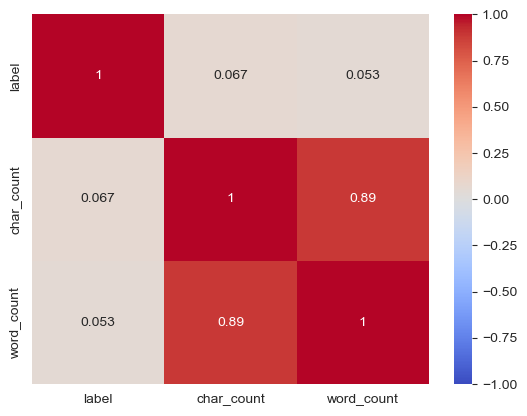

In [62]:
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap="coolwarm")

#### Targetanalyse

In [63]:
df["label"].value_counts()

0    27491
1     2012
Name: label, dtype: int64

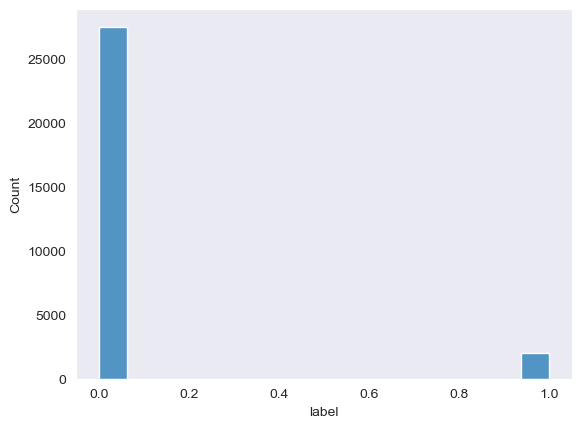

In [64]:
sns.histplot(df["label"])
plt.grid()
plt.show()

#### Featureanalyse

<Axes: xlabel='word_count', ylabel='Count'>

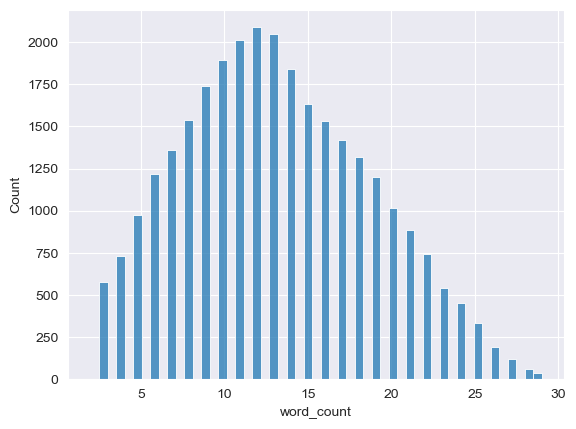

In [65]:
# Feature: Tweet - word-count
sns.histplot(df["word_count"])

In [66]:
df.word_count.describe()

count    29503.00000
mean        13.23401
std          5.53170
min          2.00000
25%          9.00000
50%         13.00000
75%         17.00000
max         29.00000
Name: word_count, dtype: float64

<Axes: xlabel='char_count', ylabel='Count'>

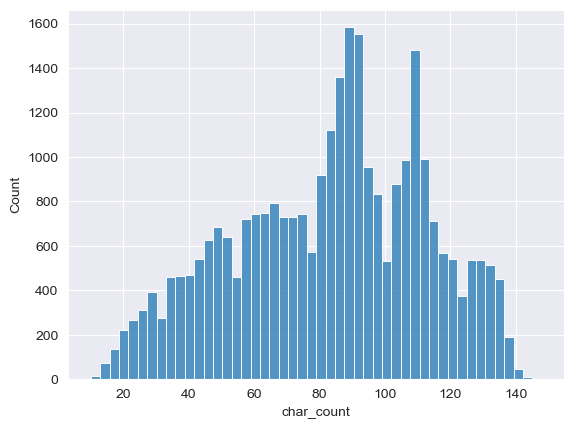

In [67]:
# Feature: Tweet - char-count
sns.histplot(df["char_count"])

In [68]:
df.char_count.describe()

count    29503.000000
mean        82.956174
std         29.383024
min         10.000000
25%         61.000000
50%         87.000000
75%        106.000000
max        148.000000
Name: char_count, dtype: float64

#### Feature x Target

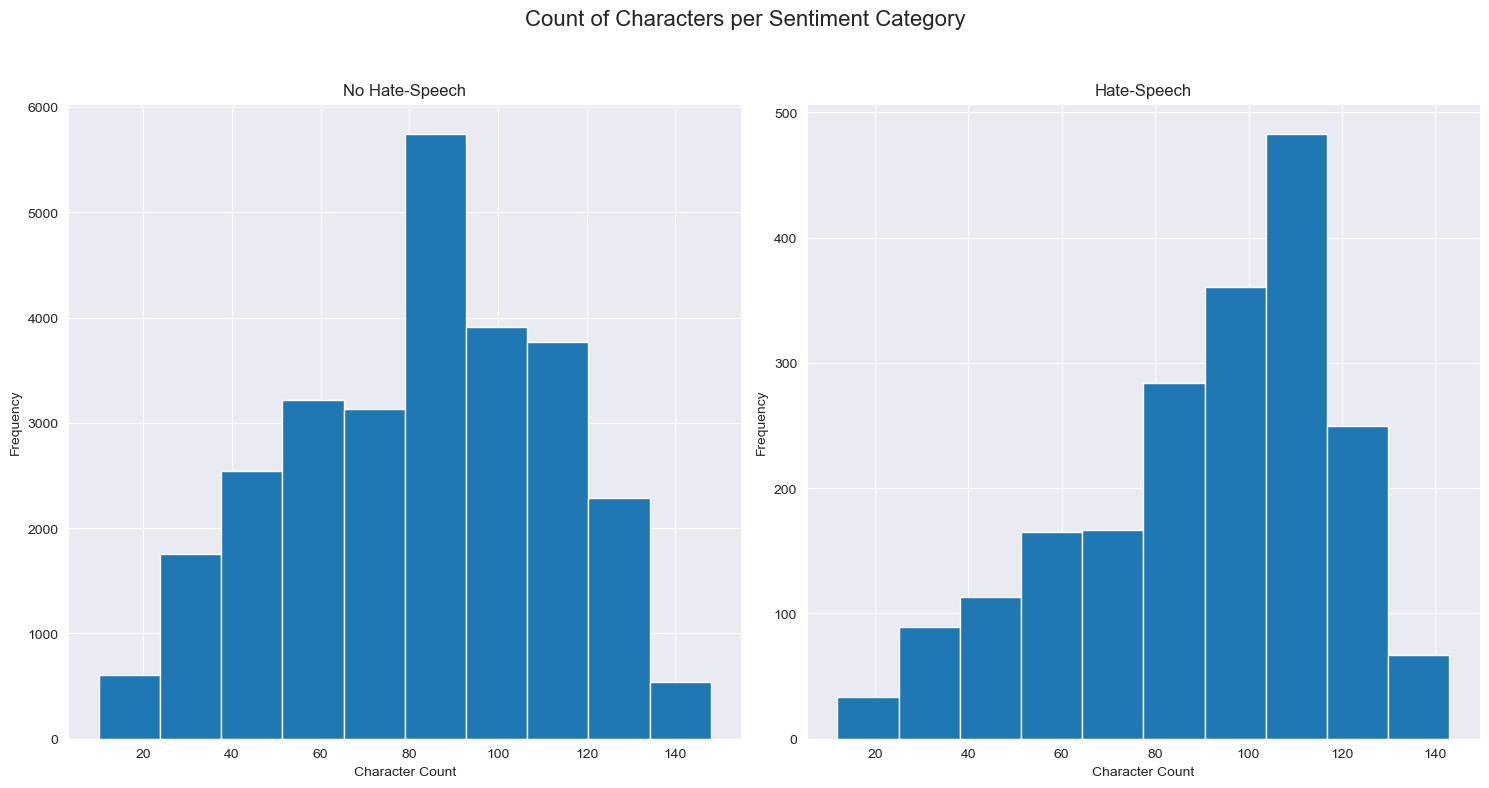

In [69]:
#Character Count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Positive Tweets
ax1.hist(df[df['label'] == 0]['char_count'])
ax1.set_title('No Hate-Speech')
ax1.set_xlabel('Character Count')
ax1.set_ylabel('Frequency')

# Negative Tweets
ax2.hist(df[df['label'] == 1]['char_count'])
ax2.set_title('Hate-Speech')
ax2.set_xlabel('Character Count')
ax2.set_ylabel('Frequency')

plt.suptitle('Count of Characters per Sentiment Category', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

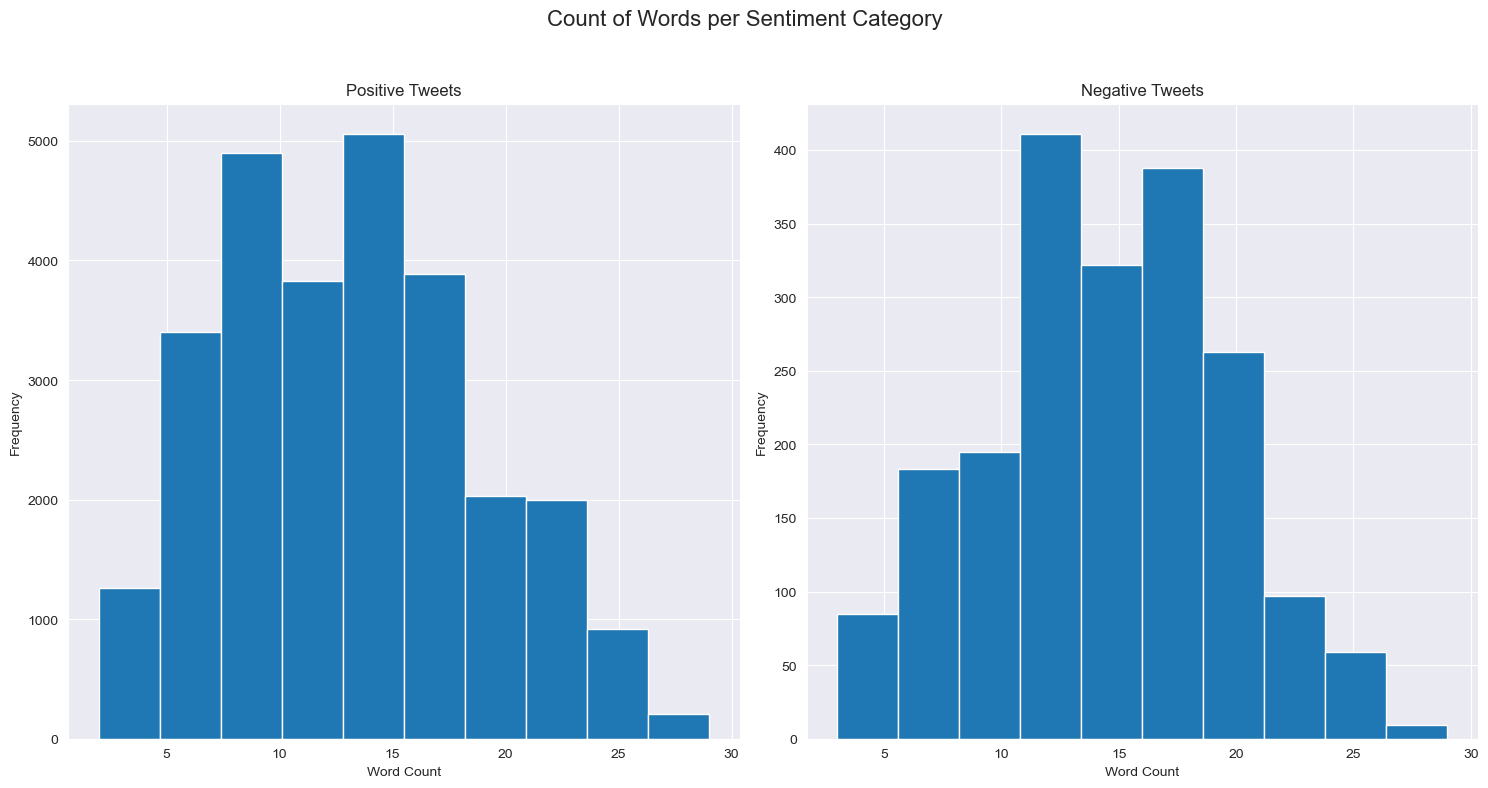

In [70]:
# Word Count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Positive Tweets
ax1.hist(df[df['label'] == 0]['word_count'])
ax1.set_title('Positive Tweets')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')

# Negative Tweets
ax2.hist(df[df['label'] == 1]['word_count'])
ax2.set_title('Negative Tweets')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')

plt.suptitle('Count of Words per Sentiment Category', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [71]:
# Häufige Wörter (nach Bereinigung) bei HS
tweet_hs = df.no_sw_lem[df.label == 1]

AttributeError: 'DataFrame' object has no attribute 'no_sw_lem'

In [ ]:
cnt_hs = Counter()
for text in tweet_hs.values:
    for word in text.split():
        cnt_hs[word] += 1
cnt_hs.most_common(20)
temp_hs = pd.DataFrame(cnt_hs.most_common(20))
temp_hs.columns = ['word', 'count']
temp_hs.head(20)

In [ ]:
sns.lineplot(data=temp_hs, y=temp_hs['word'], x=temp_hs['count'])
plt.title("Top 10 most frequent words in non-HS (no sw + lem)")

In [ ]:
# Häufige Wörter (nach Bereinigung) bei nicht-HS
tweet_nohs = df.no_sw_lem[df.label == 0]

In [ ]:
cnt_nohs = Counter()
for text in tweet_nohs.values:
    for word in text.split():
        cnt_nohs[word] += 1
cnt_nohs.most_common(20)
temp_nohs = pd.DataFrame(cnt_nohs.most_common(20))
temp_nohs.columns = ['word', 'count']

In [ ]:
temp_nohs.head(20)

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(15, 8))

sns.lineplot(data=temp_nohs, y=temp_nohs['word'], x=temp_nohs['count'], ax=ax[0])
plt.title("Top 10 most frequent words in non-HS tweet (no sw + lem)")

sns.lineplot(data=temp_hs, y=temp_hs['word'], x=temp_hs['count'], ax=ax[1])
plt.title("Top 10 most frequent words in HS tweet (no sw + lem)")